In [1]:
import logging
import time

import numpy as np
from joblib import hash, dump, load
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sys
print(os.path.abspath(''))
from os import path
sys.path.append( path.abspath(os.path.abspath('')) ) 
print(path.abspath(os.path.abspath('')) )


from microGrid.env.final_env import MyEnv as MG_two_storages_env
import microGrid.experiment.base_controllers as bc
from datetime import datetime
from microGrid.plot_MG_operation import plot_op
import tensorflow as tf
import pandas as pd
from stable_baselines3 import DQN

C:\WorkSpace\code
C:\WorkSpace\code


In [2]:
import csv 

def read_csv(f, sep=";", skip_line=0, end_line=None):
    f = open(f)
    res = None
    csv_file = csv.reader(f, delimiter=sep)
    for i, l in enumerate(csv_file):
        if i<skip_line:
            continue
        if end_line is not None and i > end_line:
            break
        if res is None:
            res= [[] for _ in l]
        for i in range(len(l)):
            res[i].append(l[i])
    return res


In [3]:
file_parse_cons = read_csv('data/conso-region-occitanie-2019-demi-h.csv')
file_parse_prod = read_csv('data/prod-region-occitanie-2019-demi-h.csv')

In [4]:
print(np.array(file_parse_prod)[:,0])

['Horodate' 'RÃ©gion' 'Code rÃ©gion' 'Plage de puissance injection'
 'FiliÃ¨re de production' 'Nb points injection'
 'Total Ã©nergie injectÃ©e (Wh)' 'Courbe Moyenne nÂ°1 (Wh)'
 'Indice reprÃ©sentativitÃ© Courbe nÂ°1 (%)' 'Courbe Moyenne nÂ°2 (Wh)'
 'Indice reprÃ©sentativitÃ© Courbe nÂ°2 (%)'
 'Courbe Moyenne nÂ°1 + nÂ°2 (Wh)'
 'Indice reprÃ©sentativitÃ© Courbe nÂ°1 + nÂ°2 (%)'
 'Jour max du mois (0/1)' 'Semaine max du mois (0/1)']


In [5]:
print(file_parse_cons[0][0],"|",file_parse_cons[7][0])
print(file_parse_prod[0][0],"|",file_parse_prod[6][0])
def cumul_data(mat_csv, column_need, column_uniqu=None, skip_line=0):
    res = []
    uniqu = dict()
    for i, val in enumerate(mat_csv[column_need]):
        if i<skip_line:
            continue
        if not bool(val.strip()):
            val=0
        if column_uniqu is None:
            res.append(float(val))
        elif mat_csv[column_uniqu][i] in uniqu:
            res[uniqu[mat_csv[column_uniqu][i]]] += float(val)
        else:
            uniqu[mat_csv[column_uniqu][i]] = len(res)
            res.append(float(val))
    return res


Horodate | Total Ã©nergie soutirÃ©e (Wh)
Horodate | Total Ã©nergie injectÃ©e (Wh)


In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

def add_n_by_n(l, n):
    res = []
    for i, val in enumerate(l):
        if i % n == 0:
            res.append(val)
        else:
            res[-1] += val
    return res


8760


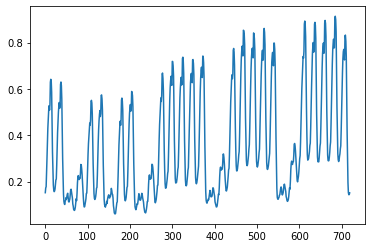

In [7]:
cons_res = cumul_data(file_parse_cons, 7, 0, skip_line=1)
cons_res2 = add_n_by_n(cons_res, 2)
print(len(cons_res2))
plt.plot(scaler.fit_transform(np.array(cons_res2).reshape(-1,1))[0:30*24])

30.416666666666668


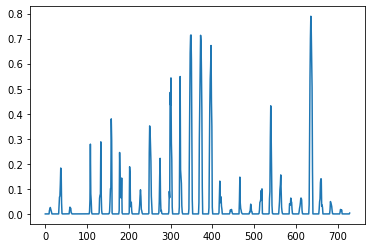

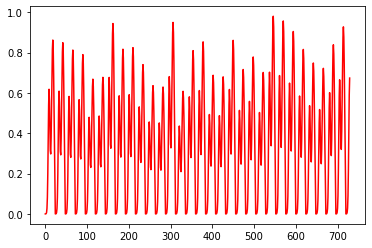

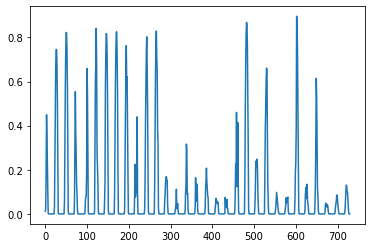

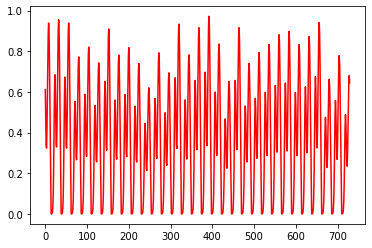

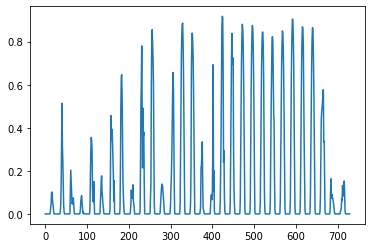

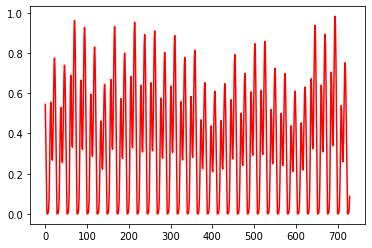

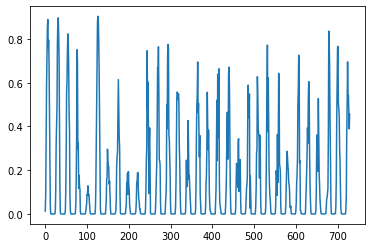

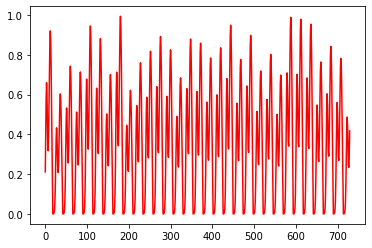

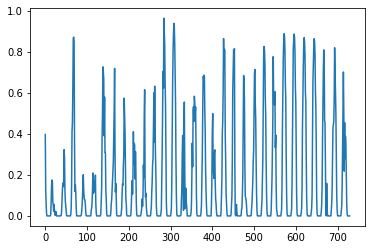

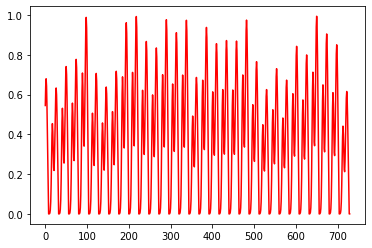

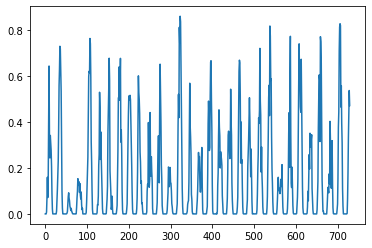

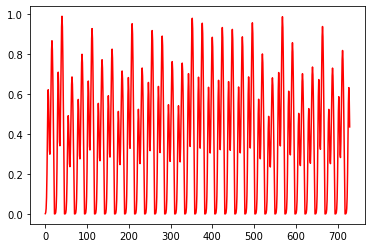

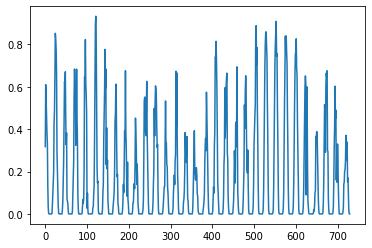

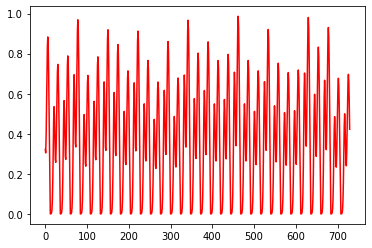

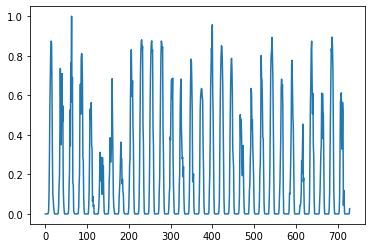

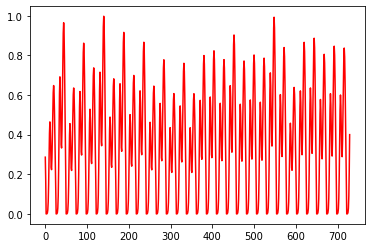

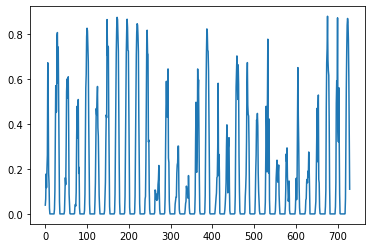

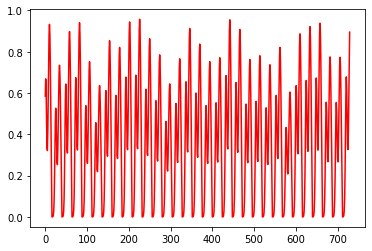

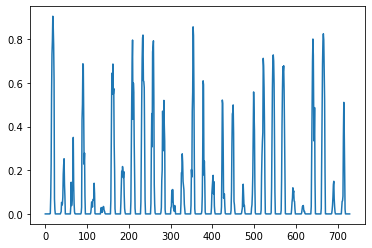

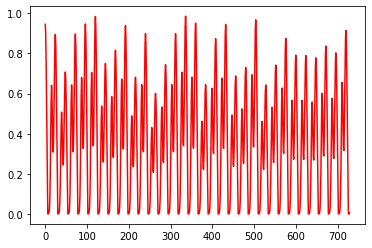

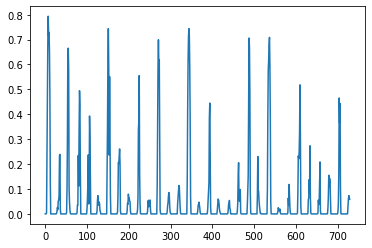

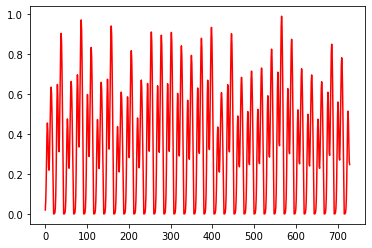

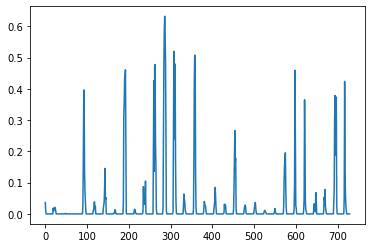

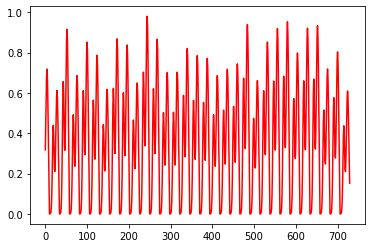

In [8]:
absolute_dir = os.path.abspath('')
prod = np.load(absolute_dir + "/microGrid/env/data/BelgiumPV_prod_test.npy")
cons = np.load(absolute_dir + "/microGrid/env/data/example_nondeterminist_cons_test.npy")
decoupe = 12
size_data = int(len(prod)/ decoupe)
print(size_data/24)
for i in range(decoupe):
    plt.plot(prod[i*size_data:(i+1)*size_data])
    plt.show()
    plt.plot(cons[i*size_data:(i+1)*size_data], color='r')
    plt.show()

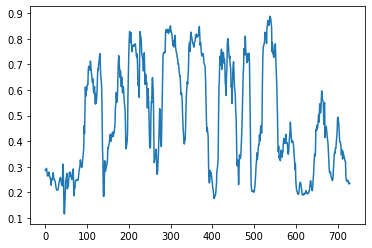

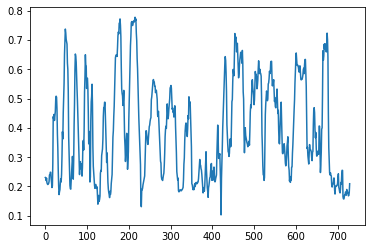

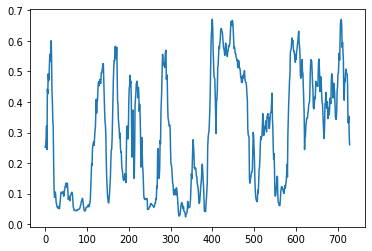

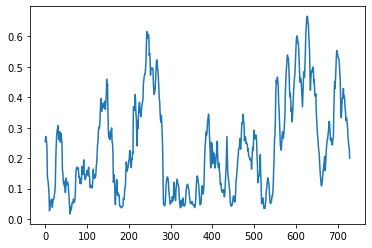

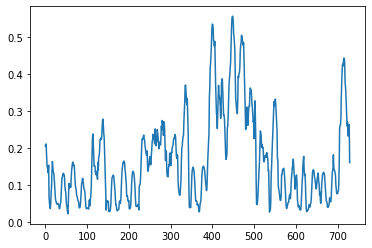

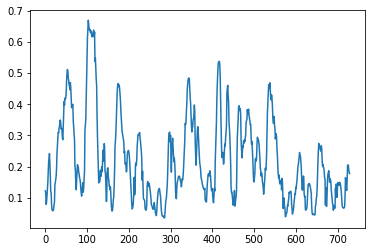

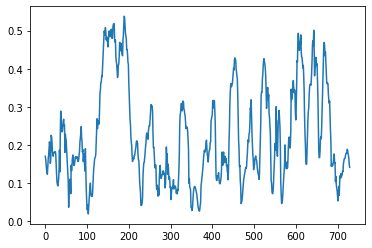

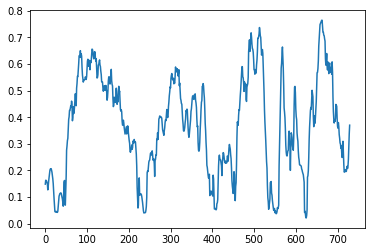

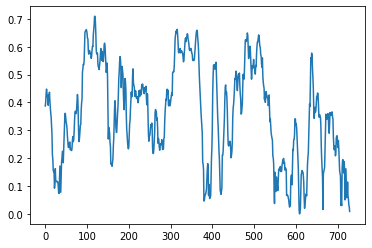

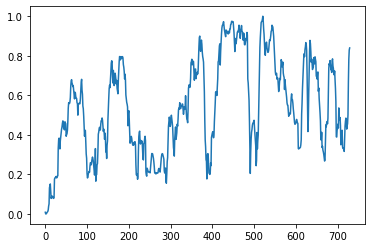

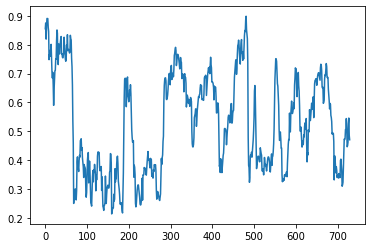

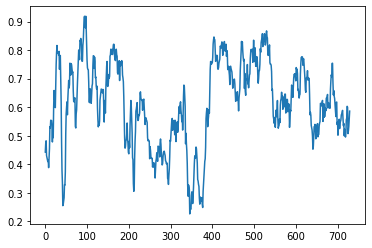

In [9]:
prod_res = cumul_data(file_parse_prod, 7, 0, skip_line=1)
prod_res2 = add_n_by_n(prod_res, 2)
for i in range(decoupe):
    plt.plot(scaler.fit_transform(np.array(prod_res2).reshape(-1,1))[i*size_data:(i+1)*size_data])
    plt.show()


['time' 'P' 'G(i)' 'H_sun' 'T2m' 'WS10m' 'Int']
(8760,)
0.1654415348020475 0.2601026093098457
0.12469619582601506 0.21892943974994133


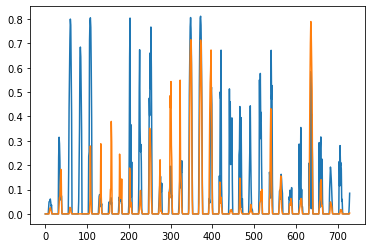

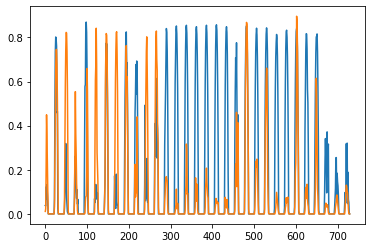

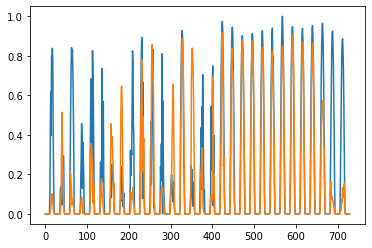

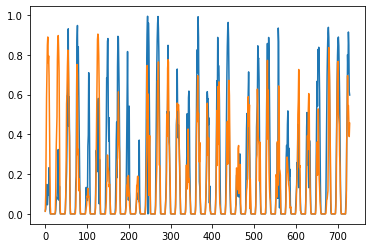

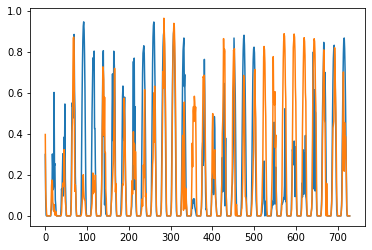

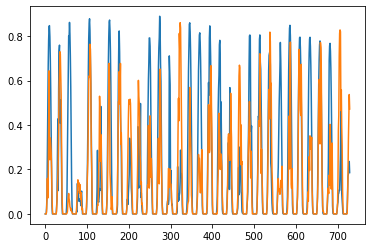

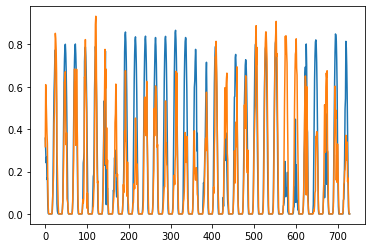

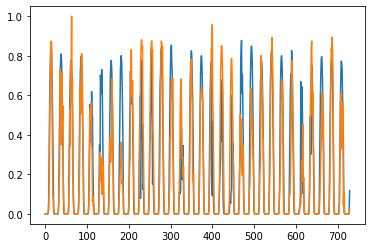

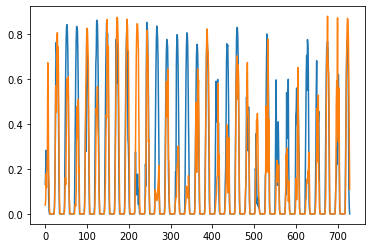

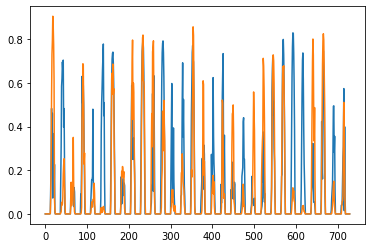

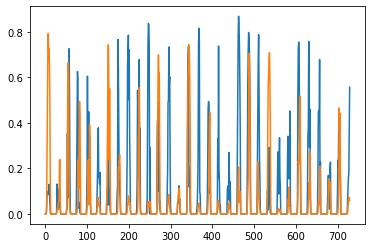

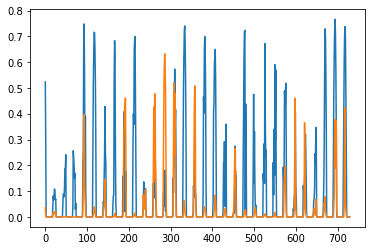

In [10]:
csv_prod2 = read_csv('data/2019_PV.csv', ";", 10, 8771)
print(np.array(csv_prod2)[:,0])
prod2 = cumul_data(csv_prod2, 1, column_uniqu=0, skip_line=1)



print(np.array(prod2).shape)
prod2 = scaler.fit_transform(np.array(prod2).reshape(-1,1))

print(np.mean(prod2), np.std(prod2))
print(np.mean(prod), np.std(prod))

for i in range(decoupe):
    plt.plot(prod2[i*size_data:(i+1)*size_data])
    plt.plot(prod[i*size_data:(i+1)*size_data])
    plt.show()

In [15]:
def plot_gene(best, dirname, filename, verbose=False):

    data = best.get_data()
    bestScores, allScores = best.get_score()
    """if len(bestScores[list(bestScores.keys())[0]]) < 5:
        shutil.rmtree(dirname + "/" + filename, ignore_errors=True)
        return"""
    print(data.keys())

    actions = data["action"]
    consumption = data["consumption"]
    production = data["production"]
    rewards = data["rewards"]
    battery_level = data["soc"]
    # plot_op(data["action"], data["consumption"], data["production"], data["rewards"], data["battery"], "test.png")
    i = 0
    plot_op(actions[0 + i:100 + i], consumption[0 + i:100 + i], production[0 + i:100 + i], rewards[0 + i:100 + i],
            battery_level[0 + i:100 + i], dirname + "/" + filename + "/" + filename + "_winter_.png")
    if verbose:
        plt.show()
    plt.clf()

    i = 180 * 24
    plot_op(actions[0 + i:100 + i], consumption[0 + i:100 + i], production[0 + i:100 + i], rewards[0 + i:100 + i],
            battery_level[0 + i:100 + i], dirname + "/" + filename + "/" + filename + "_summer_.png")
    if verbose:
        plt.show()
    plt.clf()

    i = 360 * 24
    plot_op(actions[0 + i:100 + i], consumption[0 + i:100 + i], production[0 + i:100 + i], rewards[0 + i:100 + i],
            battery_level[0 + i:100 + i], dirname + "/" + filename + "/" + filename + "_winter2_.png")
    if verbose:
        plt.show()
    plt.clf()

    key = "flow_H2"
    plt.plot(range(31 * 24), data[key][:31 * 24], label=key, color='b')
    key = "Buy_energy"
    plt.plot(range(31 * 24), data[key][:31 * 24], label=key, color='r')

    plt.legend()
    plt.xlabel("Number of hours")
    plt.ylabel("Score")
    plt.savefig(dirname + "/" + filename + "/" + filename + "_plots.png")
    if verbose:
        plt.show()
    plt.clf()

    h = sns.jointplot(x=[battery_level[i] for i in range(len(actions)) if actions[i] == 0],
                      y=[consumption[i] - production[i] for i in range(len(actions)) if actions[i] == 0],
                      kind="hist", marginal_ticks=True)
    # JointGrid has a convenience function
    h.set_axis_labels('charge battery', 'demand', fontsize=16)
    plt.savefig(dirname + "/" + filename + "/" + filename + "_plots_action0.png")
    if verbose:
        plt.show()
    plt.clf()

    h = sns.jointplot(x=[battery_level[i] for i in range(len(actions)) if actions[i] == 1],
                      y=[consumption[i] - production[i] for i in range(len(actions)) if actions[i] == 1],
                      kind="hist", marginal_ticks=True)
    # JointGrid has a convenience function
    h.set_axis_labels('charge battery', 'demand', fontsize=16)
    plt.savefig(dirname + "/" + filename + "/" + filename + "_plots_action1.png")
    if verbose:
        plt.show()
    plt.clf()

    h = sns.jointplot(x=[battery_level[i] for i in range(len(actions)) if actions[i] == 2],
                      y=[consumption[i] - production[i] for i in range(len(actions)) if actions[i] == 2],
                      kind="hist", marginal_ticks=True)
    # JointGrid has a convenience function
    h.set_axis_labels('charge battery', 'demand', fontsize=16)
    plt.savefig(dirname + "/" + filename + "/" + filename + "_plots_action2.png")
    if verbose:
        plt.show()
    plt.clf()

    demande = [consumption[i] - production[i] for i in range(len(actions))]
    print("demande moyenne : ", np.mean(demande))
    print("demande std : ", np.std(demande))

    corr = pd.DataFrame.from_dict(bestScores)
    corr = corr.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corr, annot=True)
    plt.savefig(dirname + "/" + filename + "/" + filename + "_heatmap.png")
    if verbose:
        plt.show()
    plt.clf()


    corr = pd.DataFrame.from_dict(data)
    corr = corr.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corr, annot=True)
    plt.savefig(dirname + "/" + filename + "/" + filename + "_heatmap2.png")
    if verbose:
        plt.show()
    plt.clf()
    print("reward", np.sum(data["rewards"]))

    scaler = preprocessing.MinMaxScaler()

    for k in bestScores.keys():
        try:
            plt.plot(range(len(bestScores[k])), scaler.fit_transform(np.array(bestScores[k]).reshape(-1,1)),
                     label="score " + str(k))
        except Exception as e:
            print("error",k)
            print(e)
            plt.plot(range(len(bestScores[k])), bestScores[k], label="score " + str(k))

    plt.legend()
    plt.xlabel("best step")
    plt.ylabel("normalized score")
    plt.savefig(dirname + "/" + filename + "/" + filename + "_scoresbest.png")
    if verbose:
        plt.show()
    plt.clf()

    for k in bestScores.keys():
        try:
            plt.plot(range(len(allScores[k])), allScores[k],
                     label="score " + str(k))
        except Exception as e:
            print("error",k)
            print(e)
            plt.plot(range(len(allScores[k])), allScores[k], label="score " + str(k))

    plt.legend()
    plt.xlabel("number episode")
    plt.ylabel("normalized score")
    plt.savefig(dirname + "/" + filename  + "/" + filename + "_scores.png")
    if verbose:
        plt.show()

    plt.clf()
    labels = 'discharge', 'none', 'charge'
    sizes = [len([1 for i in range(len(actions)) if actions[i] == 0]),
             len([1 for i in range(len(actions)) if actions[i] == 1]),
             len([1 for i in range(len(actions)) if actions[i] == 2])]
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)

    plt.axis('equal')

    plt.savefig(dirname + "/" + filename  + "/" + filename + 'PieChart.png')
    if verbose:
        plt.show()
    plt.clf()
    plt.close("all")


def test(dirname, filename,
         patience,
         train_freq,
         learning_rate,
         buffer_size,
         batch_size,
         discount,
         eps_decay,
         freeze,
         dict_env,
         env,
         env_valid,
         verbose = False):





    # --- init model ---
    print('MlpPolicy',
          "learning_rate=", learning_rate,
          "buffer_size=", buffer_size,
          "batch_size=", batch_size,
          "gamma=", discount,
          "exploration_initial_eps=", Defaults.EPSILON_START,
          "exploration_final_eps=", Defaults.EPSILON_MIN,
          "exploration_fraction=", eps_decay,
          "target_update_interval=", freeze,
          "size_histo=", EnvParam.LENGTH_HISTORY,
          "train_freq=", train_freq, sep='\n')
    if not os.path.exists(dirname + "/" + filename):
        os.makedirs(dirname + "/" + filename)

    f = open(dirname+ "/" + filename + "/" + filename + "hyperparam.txt", "a")
    f.write('MlpPolicy\n' +
          "learning_rate=" +  str(learning_rate) +
          "\nbuffer_size=" +  str(buffer_size) +
          "\nbatch_size=" +  str(batch_size) +
          "\ngamma=" +  str(discount) +
          "\nexploration_initial_eps=" +  str(Defaults.EPSILON_START) +
          "\nexploration_final_eps=" +  str(Defaults.EPSILON_MIN) +
          "\nexploration_fraction=" +  str(eps_decay) +
          "\ntarget_update_interval=" +  str(freeze) +
          "\ntrain_freq=" + str(train_freq))
    f.close()

    print(len(env.observation_space.sample()))

    model = DQN('MlpPolicy', env,
                learning_rate=learning_rate,
                buffer_size=buffer_size,
                batch_size=batch_size,
                gamma=discount,
                exploration_initial_eps=Defaults.EPSILON_START,
                exploration_final_eps=Defaults.EPSILON_MIN,
                exploration_fraction=eps_decay,
                target_update_interval=freeze,
                train_freq=train_freq,
                verbose=0)

    best = BestCallback(env_valid, {}, patience, filename, dirname)
    #best = BestCallback(env_valid, dict_env, patience, filename, dirname)
    try:
        start = time.time()
        model.learn(Defaults.EPOCHS * Defaults.STEPS_PER_EPOCH,
                    callback=best)  # callback=[verbose_callback, eps_callback, best_callback]
        res = time.time() - start
        print("time to train and valid:", int(res / 3600), "h", int((res % 3600) / 60), "min", res % 60, "s")
    except KeyboardInterrupt:
        print('Hello user you have KeyboardInterrupt.')
    plot_gene(best, dirname, filename, verbose=verbose)
    


C:\WorkSpace\code
C:\WorkSpace\code
Sample of the consumption profile (kW): [4.88090280e-05 4.08636652e-04 2.66459683e-03 1.35325348e-02
 5.35289841e-02 1.64925998e-01 3.95869422e-01 7.40576948e-01
 1.08118010e+00 1.23674331e+00 1.12378457e+00 8.51875992e-01
 6.28731540e-01 5.94891051e-01 7.62627204e-01 1.05973501e+00
 1.38386090e+00 1.63210044e+00 1.72495565e+00 1.63169652e+00
 1.38119778e+00 1.04620892e+00 7.09130415e-01 4.30109338e-01]
Min of the consumption profile (kW): 3.569456443385281e-05
Max of the consumption profile (kW): 2.1
Average consumption per day train (kWh): 18.56458726184315
self.production_train brefore
[0. 0. 0. ... 0. 0. 0.]
self.production_train after
[0. 0. 0. ... 0. 0. 0.]
Sample of the production profile (kW): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00225469 0.01691014 0.
 0.         0.         0.         0.         0.         0.        ]
Min of t

C:\WorkSpace\code\venv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
C:\WorkSpace\code\venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


new best best05_05_2022-16-53-49score:-22635.902302181814
train score:-23460.45975
new best best05_05_2022-16-53-49score:-2427.594724206021
train score:-3093.096475
new best best05_05_2022-16-53-49score:-2378.7833791096127
train score:-3055.341123
new best best05_05_2022-16-53-49score:-1596.85811658507
train score:-2063.143328
new best best05_05_2022-16-53-49score:-1124.4322738296687
train score:-1611.104977
new best best05_05_2022-16-53-49score:-1026.850711094754
train score:-1341.267554
time to train and valid: 0 h 7 min 58.750895261764526 s
dict_keys(['action', 'rewards', 'consumption', 'production', 'battery_h2', 'flow_H2', 'lack_energy', 'waste_energy', 'buy_energy', 'soc', 'sell_energy', 'Flow_H2', 'Buy_energy'])
In this plot, total score-107.61513700668053


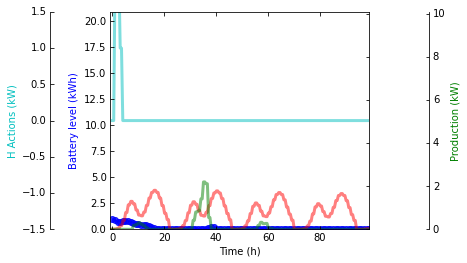

In this plot, total score5.0600000000000005


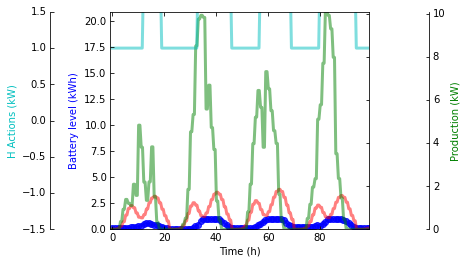

In this plot, total score-11.783528197298718


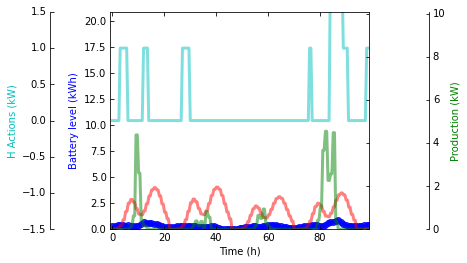

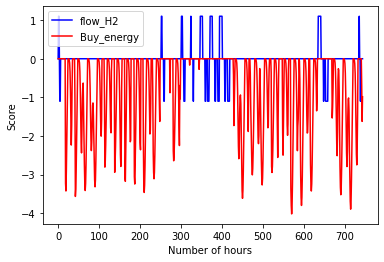

<Figure size 432x288 with 0 Axes>

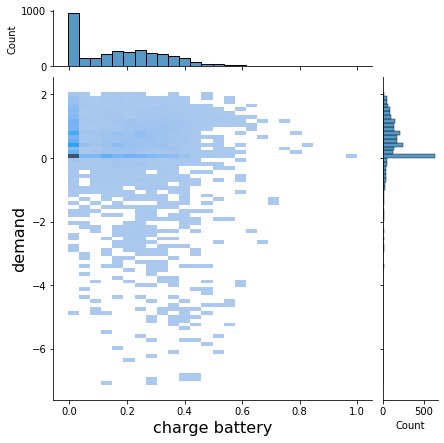

<Figure size 432x288 with 0 Axes>

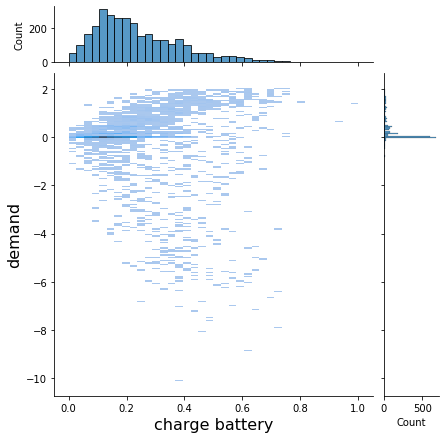

<Figure size 432x288 with 0 Axes>

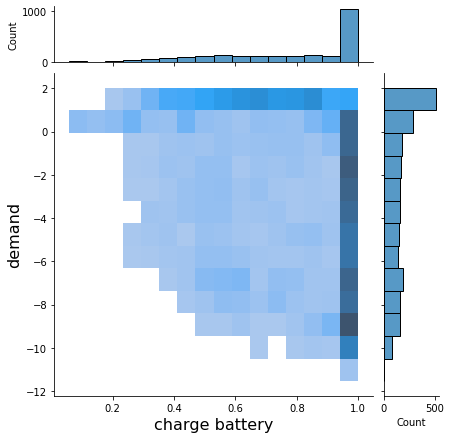

demande moyenne :  -0.7289690599108651
demande std :  2.602111036990436


<Figure size 432x288 with 0 Axes>

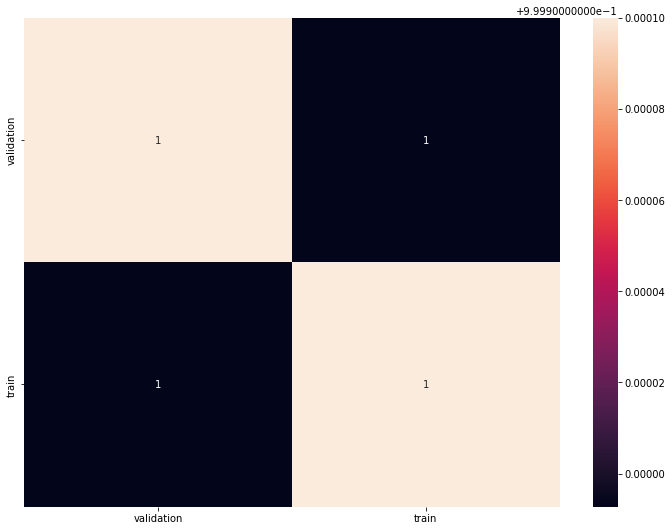

<Figure size 432x288 with 0 Axes>

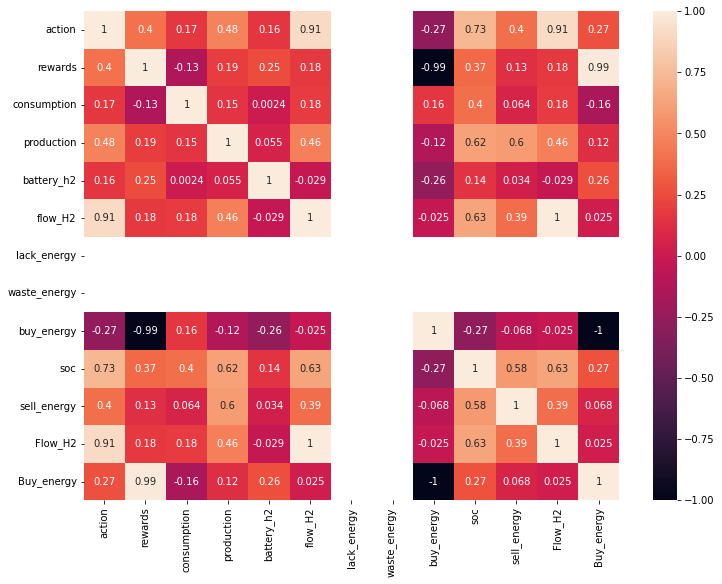

reward -1026.8507112411355


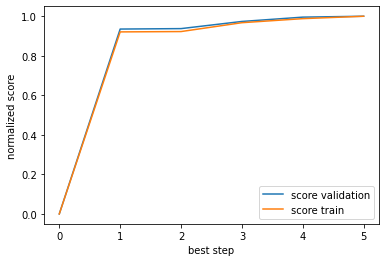

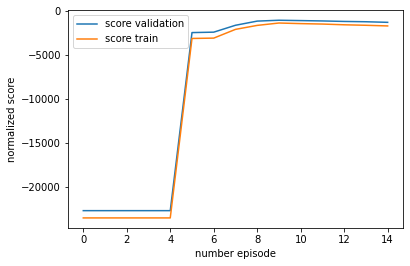

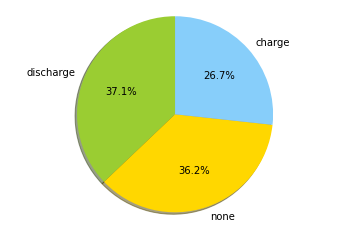

C:\WorkSpace\code\venv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Sample of the consumption profile (kW): [4.88090280e-05 4.08636652e-04 2.66459683e-03 1.35325348e-02
 5.35289841e-02 1.64925998e-01 3.95869422e-01 7.40576948e-01
 1.08118010e+00 1.23674331e+00 1.12378457e+00 8.51875992e-01
 6.28731540e-01 5.94891051e-01 7.62627204e-01 1.05973501e+00
 1.38386090e+00 1.63210044e+00 1.72495565e+00 1.63169652e+00
 1.38119778e+00 1.04620892e+00 7.09130415e-01 4.30109338e-01]
Min of the consumption profile (kW): 3.569456443385281e-05
Max of the consumption profile (kW): 2.1
Average consumption per day train (kWh): 18.56458726184315
self.production_train brefore
[0. 0. 0. ... 0. 0. 0.]
self.production_train after
[0. 0. 0. ... 0. 0. 0.]
Sample of the production profile (kW): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00225469 0.01691014 0.
 0.         0.         0.         0.         0.         0.        ]
Min of the production profile (kW): 0.0
Max 

C:\WorkSpace\code\venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


new best best05_05_2022-17-01-54score:-10471.3703843439
train score:-11071.899264
new best best05_05_2022-17-01-54score:-2575.9410426686663
train score:-3147.029247
new best best05_05_2022-17-01-54score:-1740.4949760319869
train score:-2256.524673
new best best05_05_2022-17-01-54score:-1549.3519318800245
train score:-1986.933559
new best best05_05_2022-17-01-54score:-1050.5297413051594
train score:-1497.813592
new best best05_05_2022-17-01-54score:-1033.1834669275413
train score:-1342.646484
time to train and valid: 0 h 9 min 22.437973260879517 s
dict_keys(['action', 'rewards', 'consumption', 'production', 'battery_h2', 'flow_H2', 'lack_energy', 'waste_energy', 'buy_energy', 'soc', 'sell_energy', 'Flow_H2', 'Buy_energy'])
In this plot, total score-111.07118764851347


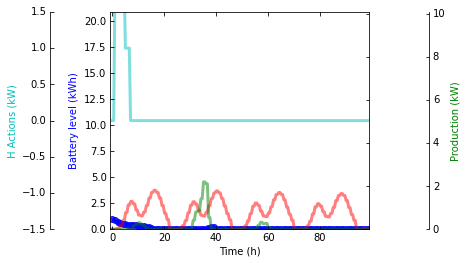

In this plot, total score5.060000000000001


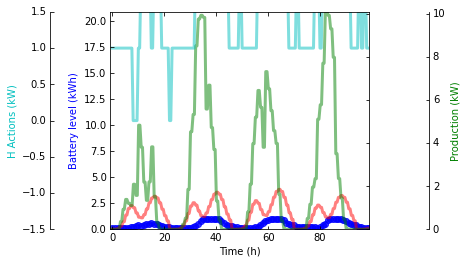

In this plot, total score-12.519463798181878


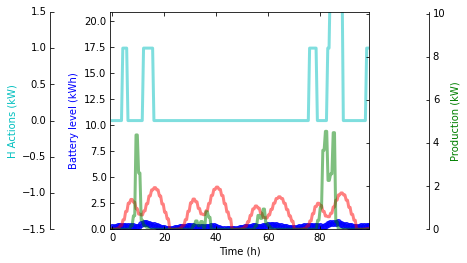

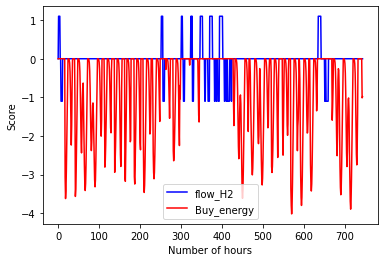

<Figure size 432x288 with 0 Axes>

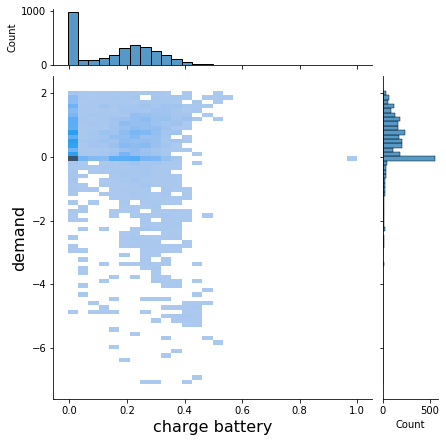

<Figure size 432x288 with 0 Axes>

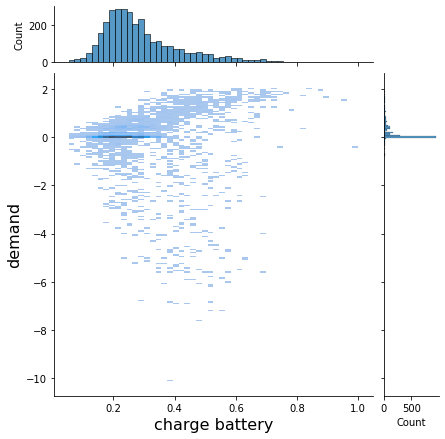

<Figure size 432x288 with 0 Axes>

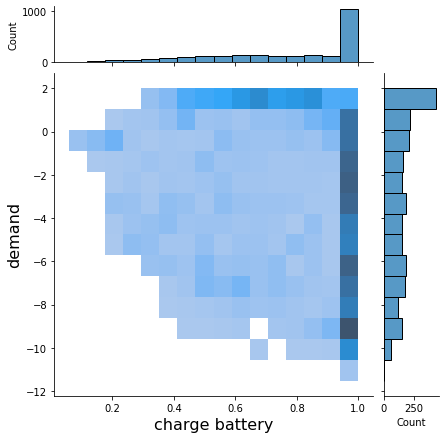

demande moyenne :  -0.7289690599108651
demande std :  2.602111036990436


<Figure size 432x288 with 0 Axes>

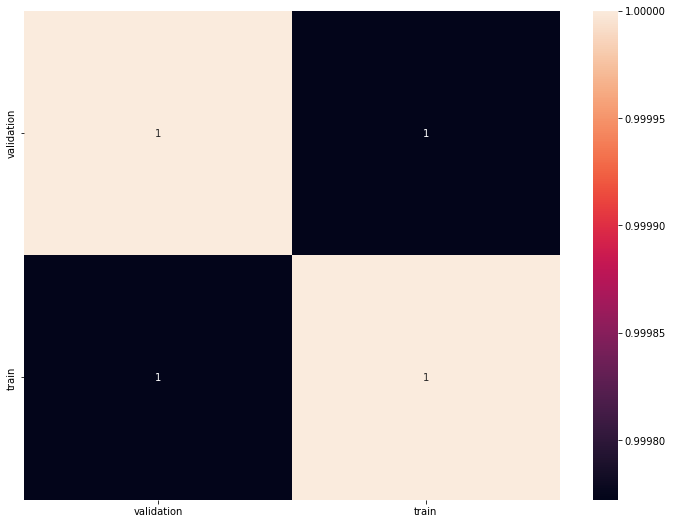

<Figure size 432x288 with 0 Axes>

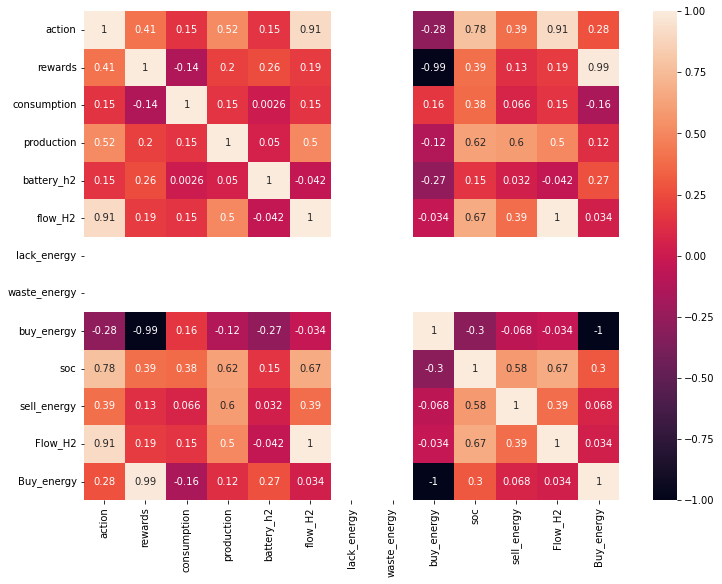

reward -1033.1834671761285


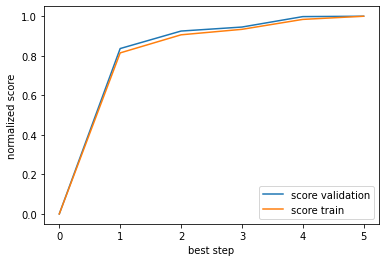

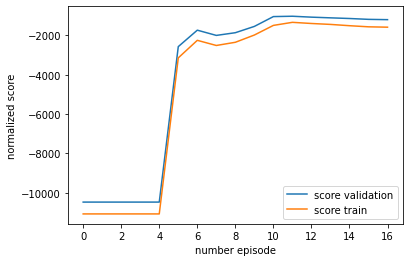

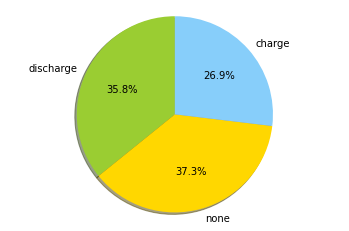

C:\WorkSpace\code\venv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Sample of the consumption profile (kW): [4.88090280e-05 4.08636652e-04 2.66459683e-03 1.35325348e-02
 5.35289841e-02 1.64925998e-01 3.95869422e-01 7.40576948e-01
 1.08118010e+00 1.23674331e+00 1.12378457e+00 8.51875992e-01
 6.28731540e-01 5.94891051e-01 7.62627204e-01 1.05973501e+00
 1.38386090e+00 1.63210044e+00 1.72495565e+00 1.63169652e+00
 1.38119778e+00 1.04620892e+00 7.09130415e-01 4.30109338e-01]
Min of the consumption profile (kW): 3.569456443385281e-05
Max of the consumption profile (kW): 2.1
Average consumption per day train (kWh): 18.56458726184315
self.production_train brefore
[0. 0. 0. ... 0. 0. 0.]
self.production_train after
[0. 0. 0. ... 0. 0. 0.]
Sample of the production profile (kW): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00225469 0.01691014 0.
 0.         0.         0.         0.         0.         0.        ]
Min of the production profile (kW): 0.0
Max 

C:\WorkSpace\code\venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


new best best05_05_2022-17-11-25score:-15903.405221111141
train score:-16787.025382
new best best05_05_2022-17-11-25score:-2119.5373541749213
train score:-2827.312298
new best best05_05_2022-17-11-25score:-1614.8802291718894
train score:-2089.722806
new best best05_05_2022-17-11-25score:-1472.6927032743406
train score:-1968.389218
new best best05_05_2022-17-11-25score:-1092.4948798166733
train score:-1631.461068
time to train and valid: 0 h 10 min 4.52401065826416 s
dict_keys(['action', 'rewards', 'consumption', 'production', 'battery_h2', 'flow_H2', 'lack_energy', 'waste_energy', 'buy_energy', 'soc', 'sell_energy', 'Flow_H2', 'Buy_energy'])
In this plot, total score-108.8993927767186


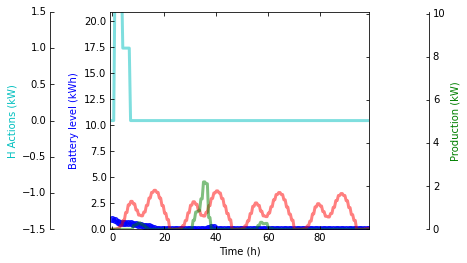

In this plot, total score4.3999999999999995


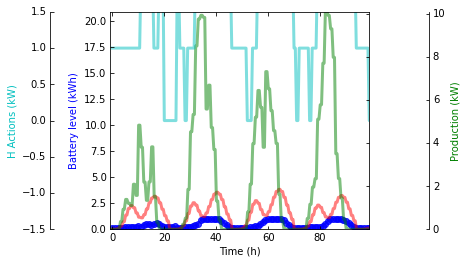

In this plot, total score-24.356336338802066


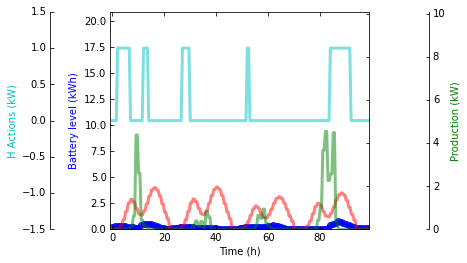

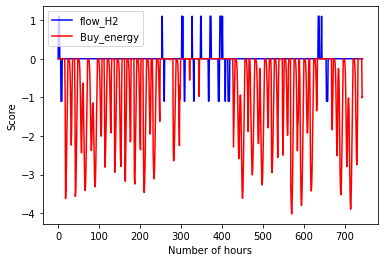

<Figure size 432x288 with 0 Axes>

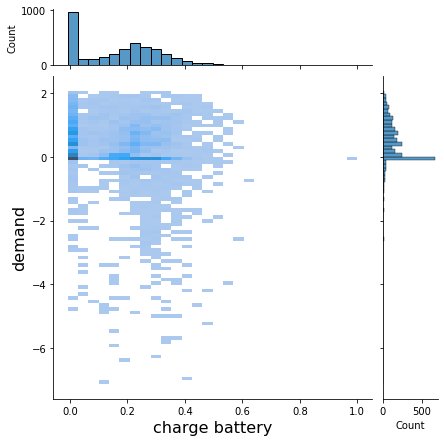

<Figure size 432x288 with 0 Axes>

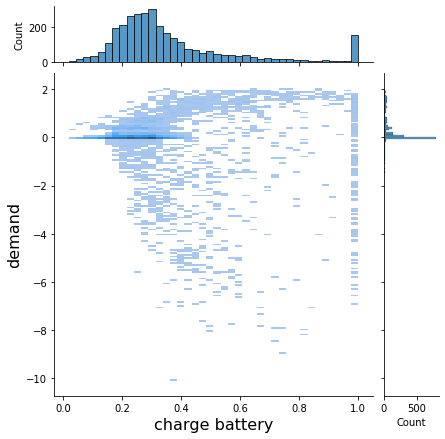

<Figure size 432x288 with 0 Axes>

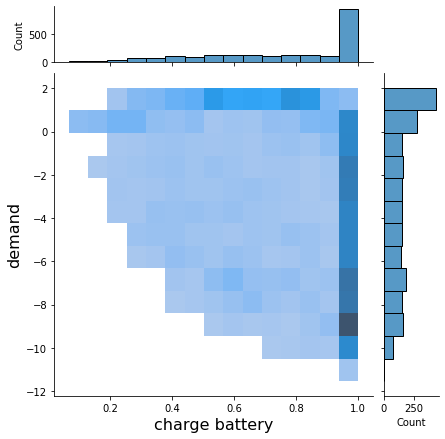

demande moyenne :  -0.7289690599108651
demande std :  2.602111036990436


<Figure size 432x288 with 0 Axes>

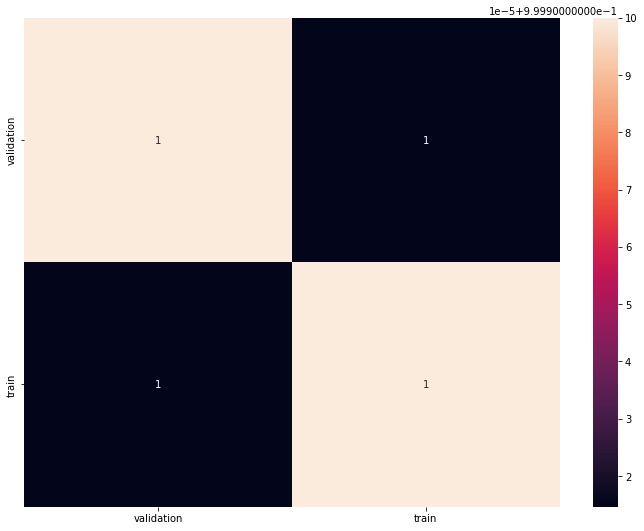

<Figure size 432x288 with 0 Axes>

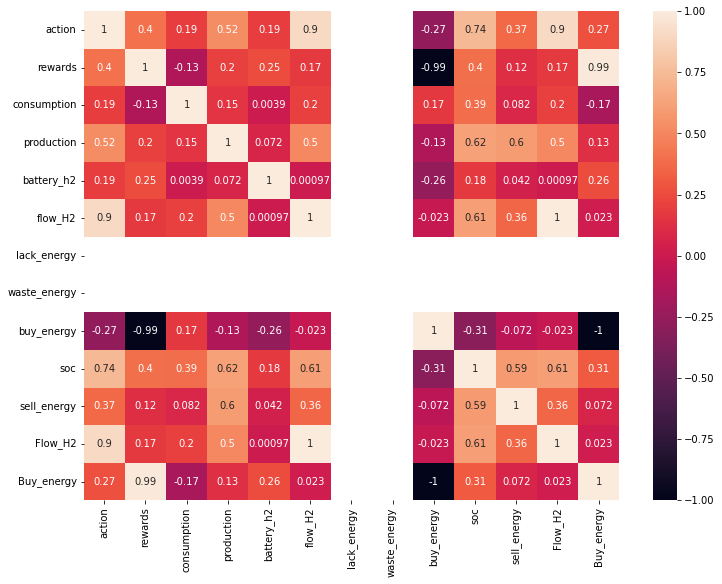

reward -1092.4948800908728


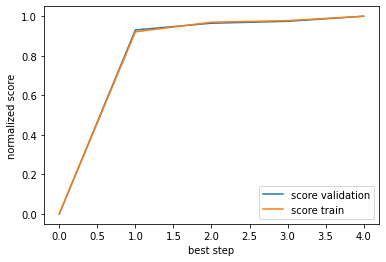

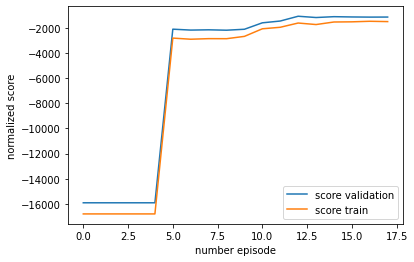

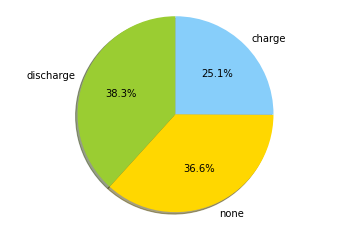

C:\WorkSpace\code\venv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Sample of the consumption profile (kW): [4.88090280e-05 4.08636652e-04 2.66459683e-03 1.35325348e-02
 5.35289841e-02 1.64925998e-01 3.95869422e-01 7.40576948e-01
 1.08118010e+00 1.23674331e+00 1.12378457e+00 8.51875992e-01
 6.28731540e-01 5.94891051e-01 7.62627204e-01 1.05973501e+00
 1.38386090e+00 1.63210044e+00 1.72495565e+00 1.63169652e+00
 1.38119778e+00 1.04620892e+00 7.09130415e-01 4.30109338e-01]
Min of the consumption profile (kW): 3.569456443385281e-05
Max of the consumption profile (kW): 2.1
Average consumption per day train (kWh): 18.56458726184315
self.production_train brefore
[0. 0. 0. ... 0. 0. 0.]
self.production_train after
[0. 0. 0. ... 0. 0. 0.]
Sample of the production profile (kW): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00225469 0.01691014 0.
 0.         0.         0.         0.         0.         0.        ]
Min of the production profile (kW): 0.0
Max 

C:\WorkSpace\code\venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


new best best05_05_2022-17-21-39score:-16080.809495671549
train score:-16961.154003
new best best05_05_2022-17-21-39score:-2466.7877022633384
train score:-3228.691043
new best best05_05_2022-17-21-39score:-2333.8431266128464
train score:-3017.006695
new best best05_05_2022-17-21-39score:-1905.4158373100217
train score:-2358.879314
new best best05_05_2022-17-21-39score:-1682.3916320779754
train score:-2203.922963
new best best05_05_2022-17-21-39score:-1353.128664444259
train score:-1895.94668
new best best05_05_2022-17-21-39score:-1075.6277311839804
train score:-1652.954554
time to train and valid: 0 h 8 min 51.75653553009033 s
dict_keys(['action', 'rewards', 'consumption', 'production', 'battery_h2', 'flow_H2', 'lack_energy', 'waste_energy', 'buy_energy', 'soc', 'sell_energy', 'Flow_H2', 'Buy_energy'])
In this plot, total score-111.09160758364351


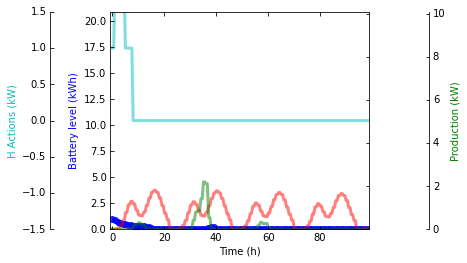

In this plot, total score4.7299999999999995


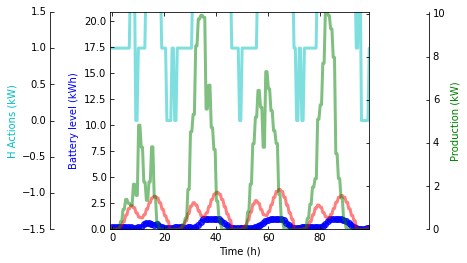

In this plot, total score-13.301526957454346


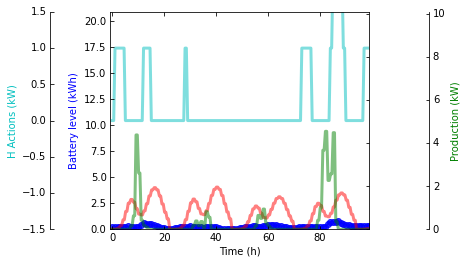

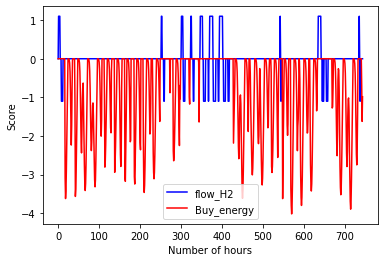

<Figure size 432x288 with 0 Axes>

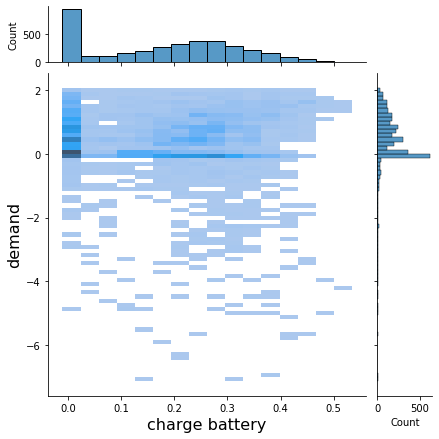

<Figure size 432x288 with 0 Axes>

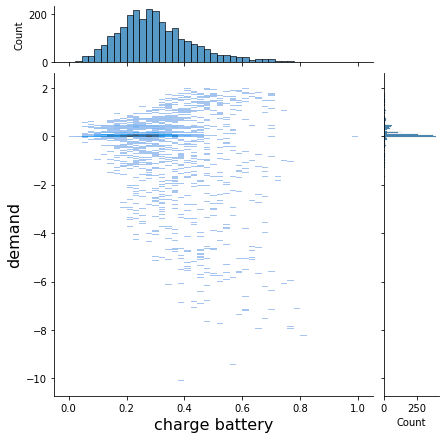

<Figure size 432x288 with 0 Axes>

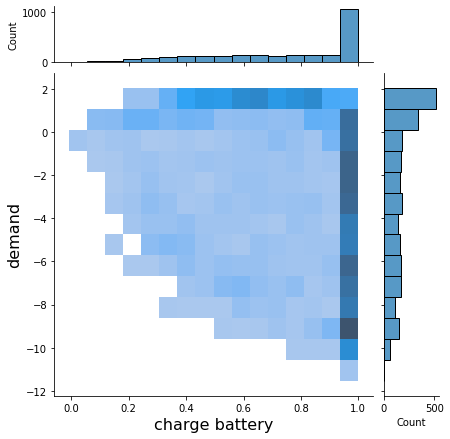

demande moyenne :  -0.7289690599108651
demande std :  2.602111036990436


<Figure size 432x288 with 0 Axes>

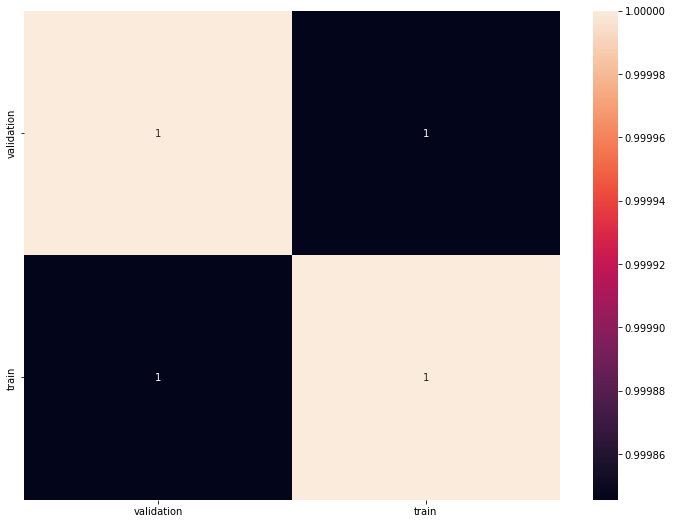

<Figure size 432x288 with 0 Axes>

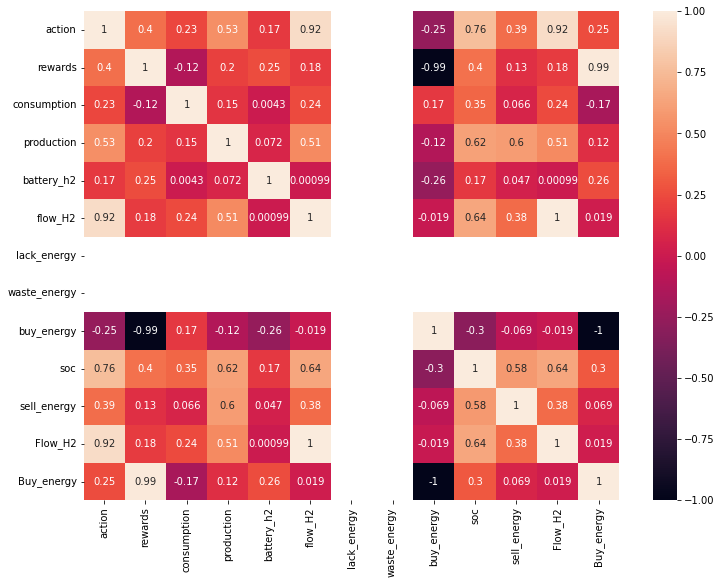

reward -1075.627731235673


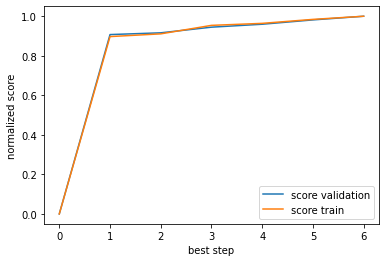

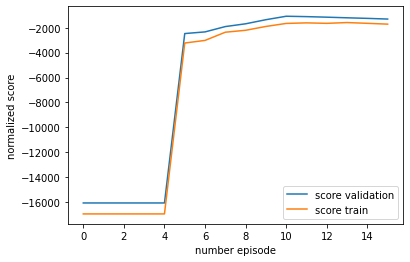

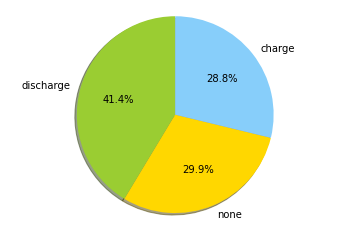

C:\WorkSpace\code\venv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Sample of the consumption profile (kW): [4.88090280e-05 4.08636652e-04 2.66459683e-03 1.35325348e-02
 5.35289841e-02 1.64925998e-01 3.95869422e-01 7.40576948e-01
 1.08118010e+00 1.23674331e+00 1.12378457e+00 8.51875992e-01
 6.28731540e-01 5.94891051e-01 7.62627204e-01 1.05973501e+00
 1.38386090e+00 1.63210044e+00 1.72495565e+00 1.63169652e+00
 1.38119778e+00 1.04620892e+00 7.09130415e-01 4.30109338e-01]
Min of the consumption profile (kW): 3.569456443385281e-05
Max of the consumption profile (kW): 2.1
Average consumption per day train (kWh): 18.56458726184315
self.production_train brefore
[0. 0. 0. ... 0. 0. 0.]
self.production_train after
[0. 0. 0. ... 0. 0. 0.]
Sample of the production profile (kW): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00225469 0.01691014 0.
 0.         0.         0.         0.         0.         0.        ]
Min of the production profile (kW): 0.0
Max 

C:\WorkSpace\code\venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


new best best05_05_2022-17-30-53score:-2436.79570018121
train score:-3106.721148
time to train and valid: 0 h 2 min 0.6034777164459229 s
dict_keys(['action', 'rewards', 'consumption', 'production', 'battery_h2', 'flow_H2', 'lack_energy', 'waste_energy', 'buy_energy', 'soc', 'sell_energy', 'Flow_H2', 'Buy_energy'])
In this plot, total score-103.16673168198685


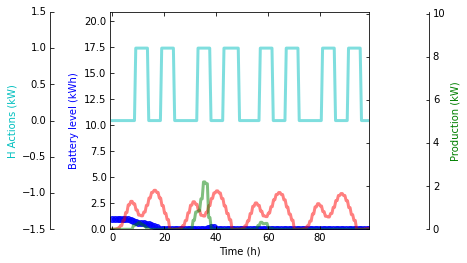

In this plot, total score0.0


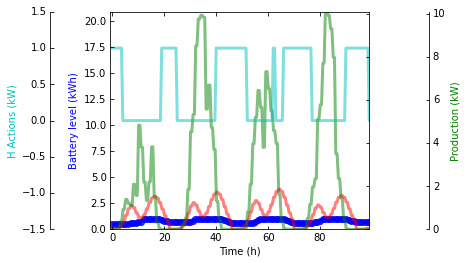

In this plot, total score-97.84879740438402


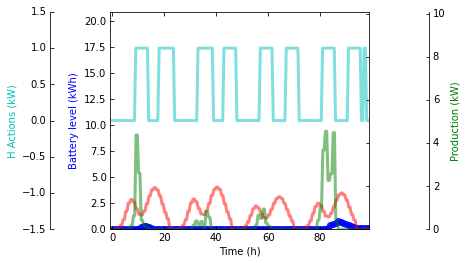

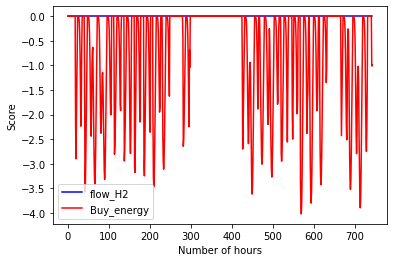

<Figure size 432x288 with 0 Axes>

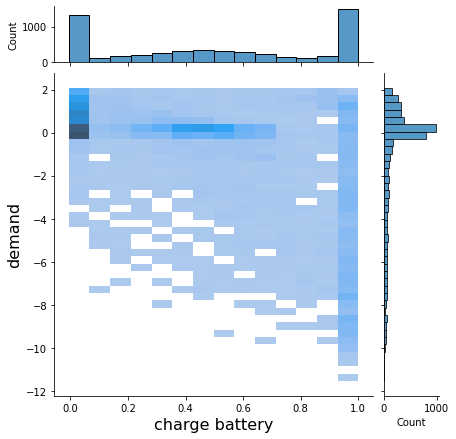

<Figure size 432x288 with 0 Axes>

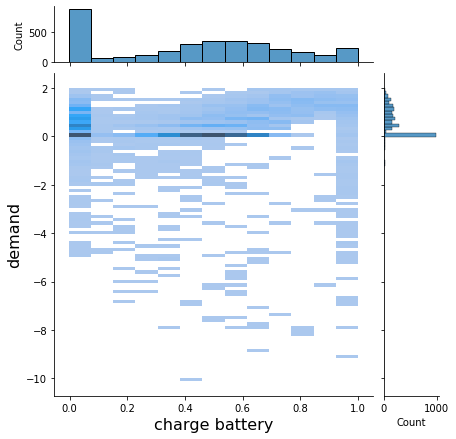

<Figure size 432x288 with 0 Axes>

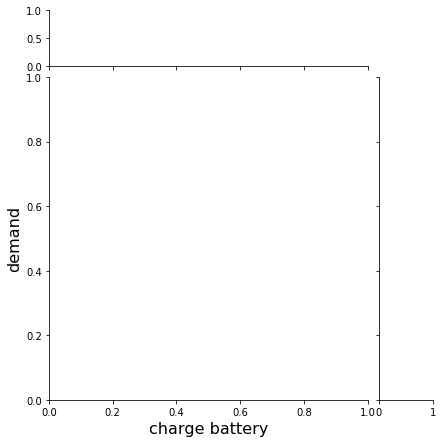

demande moyenne :  -0.7289690599108651
demande std :  2.602111036990436


C:\WorkSpace\code\venv\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\WorkSpace\code\venv\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Figure size 432x288 with 0 Axes>

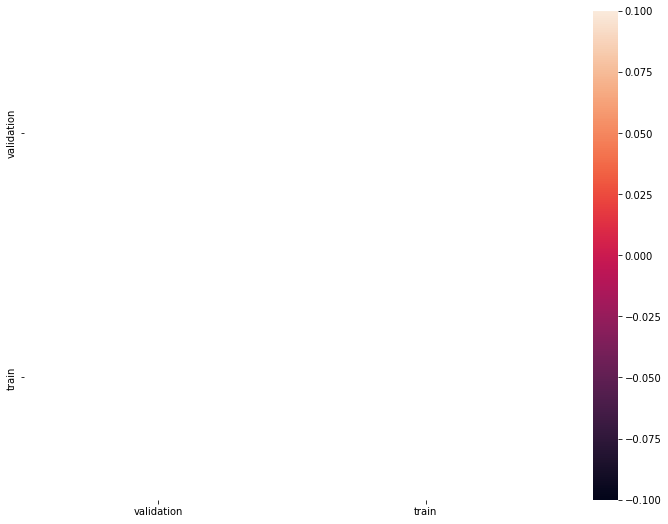

<Figure size 432x288 with 0 Axes>

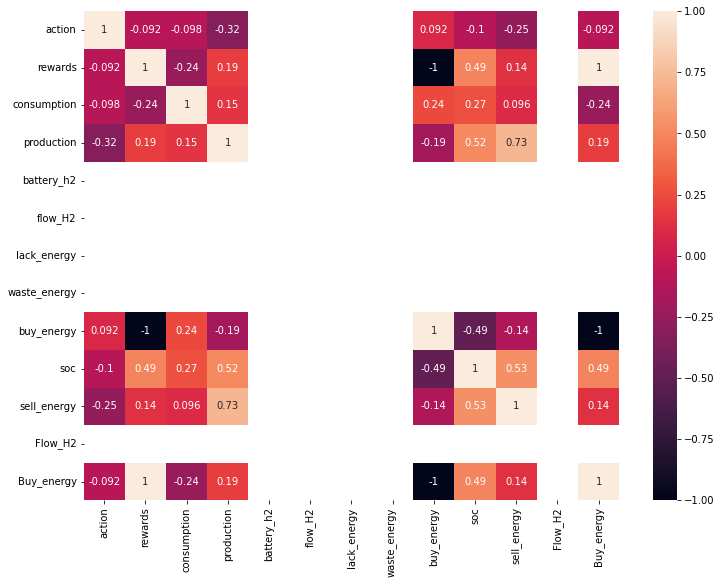

reward -2436.795701265293


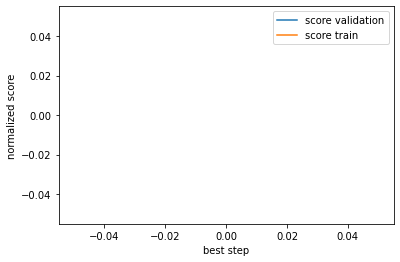

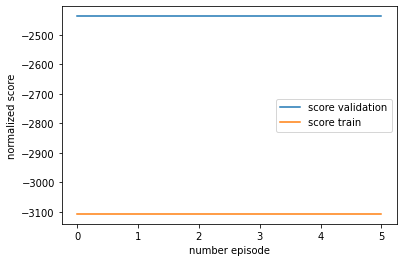

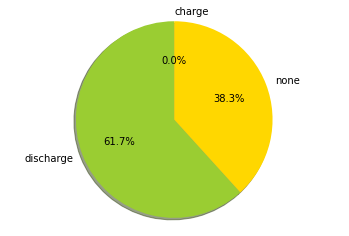

In [39]:
import logging

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import sys
import time

import tensorflow as tf
import pandas as pd
from stable_baselines3 import DQN

from sklearn import preprocessing
from microGrid.reward.reward import ClientReward

from datetime import datetime
import shutil

print(os.path.abspath(''))

sys.path.append(os.path.abspath(os.path.abspath('')))
print(os.path.abspath(os.path.abspath('')))


from microGrid.env.final_env import MyEnv as MG_two_storages_env
from microGrid.callback.callback import BestCallback
from microGrid.plot_MG_operation import plot_op


class Defaults:
    # ----------------------
    # Experiment Parameters
    # ----------------------
    STEPS_PER_EPOCH = 365 * 24 - 1
    EPOCHS = 200
    STEPS_PER_TEST = 365 * 24 - 1
    PERIOD_BTW_SUMMARY_PERFS = -1  # Set to -1 for avoiding call to env.summarizePerformance

    # ----------------------
    # Environment Parameters
    # ----------------------
    FRAME_SKIP = 1

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    UPDATE_RULE = 'rmsprop'
    LEARNING_RATE = 2e-2
    LEARNING_RATE_DECAY = 0.99
    DISCOUNT = 0.99
    DISCOUNT_INC = 0.99
    DISCOUNT_MAX = 0.98
    EPSILON_START = 1.0
    EPSILON_MIN = .1
    EPSILON_DECAY = 2.3e-7
    REPLAY_MEMORY_SIZE = 1000000
    BATCH_SIZE = 512#32
    FREEZE_INTERVAL = 1000
    DETERMINISTIC = False
    TARGET_UPDATE_INTERVAL = 2

class EnvParam:
    MAX_BUY_ENERGY = None
    MAX_SELL_ENERGY = 0
    PREDICTION = False
    EQUINOX = True
    LENGTH_HISTORY = 12

def main():
    patience = 5
    dirname = "result_noteook"
    rng = np.random.RandomState()

    # --- Instantiate environment ---
    dict_env = dict()

    env = MG_two_storages_env(rng, pred=EnvParam.PREDICTION, dist_equinox=EnvParam.EQUINOX,
                              length_history=EnvParam.LENGTH_HISTORY, max_ener_buy=EnvParam.MAX_BUY_ENERGY,
                              max_ener_sell=EnvParam.MAX_SELL_ENERGY)
    absolute_dir = os.path.abspath('')
    prod = np.load(absolute_dir + "/microGrid/env/data/BelgiumPV_prod_test.npy")[0:1 * 365 * 24]
    cons = np.load(absolute_dir + "/microGrid/env/data/example_nondeterminist_cons_test.npy")[0:1 * 365 * 24]
    env_valid = MG_two_storages_env(rng, consumption=cons, production=prod,
                                    pred=EnvParam.PREDICTION, dist_equinox=EnvParam.EQUINOX,
                                    length_history=EnvParam.LENGTH_HISTORY, max_ener_buy=EnvParam.MAX_BUY_ENERGY,
                                    max_ener_sell=EnvParam.MAX_SELL_ENERGY)

    # optimisation énergie
    env_ener = MG_two_storages_env(rng, consumption=cons, production=prod,
                                   pred=EnvParam.PREDICTION, dist_equinox=EnvParam.EQUINOX,
                                   length_history=EnvParam.LENGTH_HISTORY, max_ener_buy=EnvParam.MAX_BUY_ENERGY,
                                   max_ener_sell=EnvParam.MAX_SELL_ENERGY)
    dict_env["energy"] = env_ener
    # ressenti client
    env_user = MG_two_storages_env(rng, consumption=cons, production=prod,
                                   pred=EnvParam.PREDICTION, dist_equinox=EnvParam.EQUINOX,
                                   length_history=EnvParam.LENGTH_HISTORY, max_ener_buy=EnvParam.MAX_BUY_ENERGY,
                                   max_ener_sell=EnvParam.MAX_SELL_ENERGY)
    dict_env["user"] = env_user
    # profit réseau
    env_profit = MG_two_storages_env(rng, consumption=cons, production=prod,
                                     pred=EnvParam.PREDICTION, dist_equinox=EnvParam.EQUINOX,
                                     length_history=EnvParam.LENGTH_HISTORY, max_ener_buy=EnvParam.MAX_BUY_ENERGY,
                                     max_ener_sell=EnvParam.MAX_SELL_ENERGY)
    dict_env["profit"] = env_profit
    # préservation des stockages
    env_stockage = MG_two_storages_env(rng, consumption=cons, production=prod,
                                       pred=EnvParam.PREDICTION, dist_equinox=EnvParam.EQUINOX,
                                       length_history=EnvParam.LENGTH_HISTORY, max_ener_buy=EnvParam.MAX_BUY_ENERGY,
                                       max_ener_sell=EnvParam.MAX_SELL_ENERGY)
    dict_env["stockage"] = env_stockage

    # --- Instantiate reward parameters ---
    price_h2 = 0.1  # 0.1euro/kWh of hydrogen
    price_elec_buy = 2.0  # 2euro/kWh
    cost_wast = 0.1  # arbitrary value
    reward_client = ClientReward()

    # --- comparative reward ---
    dict_env["energy"].add_reward("Waste", lambda x: -x["waste_energy"] * cost_wast, 1.)
    dict_env["profit"].add_reward("Profit", lambda x: (x["sell_energy"] - x["buy_energy"]) * price_elec_buy, 1.)
    dict_env["user"].add_reward("Dissatisfaction", lambda x: reward_client.fn(x), 1.)

    # --- train reward ---
    env.add_reward("Flow_H2", lambda x: x["flow_H2"] * price_h2, 1.)
    env.add_reward("Buy_energy", lambda x: -x["buy_energy"] * price_elec_buy, 1.)

    # --- validation reward ---
    env_valid.add_reward("Flow_H2", lambda x: x["flow_H2"] * price_h2, 1.)
    env_valid.add_reward("Buy_energy", lambda x: -x["buy_energy"] * price_elec_buy, 1.)

    print("tensorflow work with:", tf.test.gpu_device_name())
    pow_lr = 5
    decay = 8
    logging.basicConfig(level=logging.INFO)
    train_freq = 2
    pow_replaybuff_size = 5
    pow_buff_size = 7
    discount= 0.3
    decay = 4*10**(-6)
    freeze = 1
    
    now = datetime.now()
    # dd_mm_YY-H-M-S
    dt_string = now.strftime("%d_%m_%Y-%H-%M-%S")
    filename = "best" + dt_string
    test(dirname, filename,
         patience,
         train_freq,
         learning_rate= 10**(-pow_lr),
         buffer_size= 10**(pow_replaybuff_size),
         batch_size = 2**(pow_buff_size),
         discount= discount,
         eps_decay=decay,
         freeze = freeze,
         dict_env={},
         env=env,
         env_valid=env_valid,
         verbose=True)
for _ in range(5):
    main()

In [ ]:
regarder la taille neuronei